In [1]:
import numpy as np
import pandas as pd
from data_reader import read_consumption_and_weather
from data_reader_holdout import read_consumption_and_weather_holdout
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from utils import *

from base_model import BaseModel

torch.manual_seed(1)

In [2]:
def preprocess(holdout:bool=False):
    if holdout:
        _, _, df = read_consumption_and_weather_holdout()
    else:
        _, _, df = read_consumption_and_weather()

    df1 = df['NO1']
    df2 = df['NO2']
    df3 = df['NO3']
    df4 = df['NO4']
    df5 = df['NO5']

    consumption = df1['consumption'].shift(periods=1, fill_value=0)
    target = df1['consumption']
    temp = df1['temperature'].shift(periods=1, fill_value=0)
    temp_forecast = df1['temperature']
    
    hour = pd.Series(df1.index.hour, name="hour_next_t")
    day = pd.Series(df1.index.day, name="day_next_t")
    month = pd.Series(df1.index.month, name="month_next_t")
    year = pd.Series(df1.index.year, name="year_next_t")

    # Concatenate temperature and forecast so that each row contains temp, next day forecast
    df_ = pd.concat([temp_forecast, consumption, target], axis=1)
    df_ = df_.assign(hour_next_t=hour.values)
    df_ = df_.assign(day_next_t=day.values)
    df_ = df_.assign(month_next_t=month.values)
    df_ = df_.assign(year_next_t=year.values)
    df_.columns = ['forecast', 'consumption', 'next_timestep_consumption', 'hour_next_t', 'day_next_t', 'month_next_t', 'year_next_t']
    df_ = df_.tail(-1)
    
    return df_


In [3]:
# _, _, df = read_consumption_and_weather()

# df1 = df['NO1']
# df2 = df['NO2']
# df3 = df['NO3']
# df4 = df['NO4']
# df5 = df['NO5']

# consumption = df1['consumption'].shift(periods=1, fill_value=0)
# target = df1['consumption']
# temp = df1['temperature'].shift(periods=1, fill_value=0)
# temp_forecast = df1['temperature']

In [4]:
# hour = pd.Series(df1.index.hour, name="hour_next_t")
# day = pd.Series(df1.index.day, name="day_next_t")
# month = pd.Series(df1.index.month, name="month_next_t")
# year = pd.Series(df1.index.year, name="year_next_t")


In [5]:
# # Concatenate temperature and forecast so that each row contains temp, next day forecast
# df_ = pd.concat([temp_forecast, consumption, target], axis=1)
# df_ = df_.assign(hour_next_t=hour.values)
# df_ = df_.assign(day_next_t=day.values)
# df_ = df_.assign(month_next_t=month.values)
# df_ = df_.assign(year_next_t=year.values)
# df_.columns = ['forecast', 'consumption', 'next_timestep_consumption', 'hour_next_t', 'day_next_t', 'month_next_t', 'year_next_t']
# df_ = df_.tail(-1)
# df_.head()

In [6]:
df_ = preprocess(holdout=False)

# df_holdout = preprocess(holdout=True)

Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False


In [7]:
# Get the 0.8 first timesteps for training and 0.2 last one for testing
df_train, df_test = train_test_split(df_, test_size=0.2, shuffle=False)
# Divide into train, validation
df_train, df_validation = train_test_split(df_train, test_size=0.1)

In [8]:
# Save for undoing normalization in testing
train_mean = df_train.mean()
train_std = df_train.std()

# Normalize train and test set
df_train = (df_train - train_mean) / train_std
df_validation = (df_validation - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

# df_holdout = (df_holdout - train_mean) / train_std

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10042 entries, 2021-11-29 14:00:00+00:00 to 2023-01-21 23:00:00+00:00
Freq: H
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   forecast                   10042 non-null  float64
 1   consumption                10042 non-null  float64
 2   next_timestep_consumption  10042 non-null  float64
 3   hour_next_t                10042 non-null  float64
 4   day_next_t                 10042 non-null  float64
 5   month_next_t               10042 non-null  float64
 6   year_next_t                10042 non-null  float64
dtypes: float64(7)
memory usage: 627.6 KB


Resulting DataFrame on form: "Date/Time t+1", "Temperature t", "Temperature t+1 (forecast)", "Consumption t", "Consumption t+1 (target)"

In [10]:
# Make Pytorch compatible dataloader
target_train = torch.tensor(df_train['next_timestep_consumption'].values.astype(np.float32))
features_train = torch.tensor(df_train.drop('next_timestep_consumption', axis=1).values.astype(np.float32))

target_val = torch.tensor(df_validation['next_timestep_consumption'].values.astype(np.float32))
features_val = torch.tensor(df_validation.drop('next_timestep_consumption', axis=1).values.astype(np.float32))

target_test = torch.tensor(df_test['next_timestep_consumption'].values.astype(np.float32))
features_test = torch.tensor(df_test.drop('next_timestep_consumption', axis=1).values.astype(np.float32))

# target_holdout = torch.tensor(df_holdout['next_timestep_consumption'].values.astype(np.float32))
# features_holdout = torch.tensor(df_holdout.drop('next_timestep_consumption', axis=1).values.astype(np.float32))


In [11]:
train_tensor = torch.utils.data.TensorDataset(features_train, target_train)
train_loader = torch.utils.data.DataLoader(dataset=train_tensor, batch_size=64, shuffle=True)

val_tensor = torch.utils.data.TensorDataset(features_val, target_val)
val_loader = torch.utils.data.DataLoader(dataset=val_tensor, batch_size=64, shuffle=False)

test_tensor = torch.utils.data.TensorDataset(features_test, target_test)
test_loader = torch.utils.data.DataLoader(dataset=test_tensor, batch_size=25, shuffle=False)

# holdout_tensor = torch.utils.data.TensorDataset(features_holdout, target_holdout)
# holdout_loader = torch.utils.data.DataLoader(dataset=holdout_tensor, batch_size=25, shuffle=False)

In [17]:
loss_fn = torch.nn.MSELoss()

model = BaseModel()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

losses = []
losses_show = []
val_losses = []

# Training
for epoch in range(50):
    epoch_loss = []
    for i, data in enumerate(train_loader):
        features, targets = data

        # Make predictions for this batch
        outputs = model(features)

        # Compute loss and gradients
        loss = loss_fn(outputs, targets.view(-1, 1))
        
        # Zero gradients
        optimizer.zero_grad()

        loss.backward()

        # Update weights 
        optimizer.step()

        losses.append(loss.item())
        epoch_loss.append(loss.item())
        if len(losses) > 20:
            losses_show.append(sum(losses[-20:]) / 20)
        else:
            losses_show.append(losses[-1])

    # Validation Step
    val_loss = []
    for i, data in enumerate(val_loader):
        f, t = data
        output = model(f)
        loss = loss_fn(output, t.view(-1, 1))
        val_loss.append(loss.item())
    
    avg_val_loss = sum(val_loss) / len(val_loss)
    avg_train_loss = sum(epoch_loss) / len(epoch_loss)
    print(f"Epoch {epoch} | train loss: {avg_train_loss} val loss: {avg_val_loss}")

    val_losses.append(avg_val_loss)


Epoch 0 | train loss: 0.23882524610488814 val loss: 0.027716925219883993
Epoch 1 | train loss: 0.01836228994487793 val loss: 0.015141703528425997
Epoch 2 | train loss: 0.014066078999302293 val loss: 0.013479067042233452
Epoch 3 | train loss: 0.012601711772448194 val loss: 0.012239559531389247
Epoch 4 | train loss: 0.01140297762472677 val loss: 0.011094862905641397
Epoch 5 | train loss: 0.010458506127011723 val loss: 0.010408887831819437
Epoch 6 | train loss: 0.009829253078627902 val loss: 0.009893282856200896
Epoch 7 | train loss: 0.009446918316581081 val loss: 0.009711350240404643
Epoch 8 | train loss: 0.009238543473101692 val loss: 0.009461002357836281
Epoch 9 | train loss: 0.009047943436895061 val loss: 0.00954917391082124
Epoch 10 | train loss: 0.008899416774923428 val loss: 0.009247944601589725
Epoch 11 | train loss: 0.008770612480151837 val loss: 0.009175327776502522
Epoch 12 | train loss: 0.008664148109676563 val loss: 0.008945931251796465
Epoch 13 | train loss: 0.00858207937840

In [18]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
  model.eval()
  predictions, actuals = [], []
  test_loss = []
  device = next(model.parameters()).device
  for x, y in unshuffled_dataloader:
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
      p = model(x)
      loss = loss_fn(p, y).item()
      test_loss.append(loss)
      predictions.append(p)
      actuals.append(y.squeeze())
  predictions = torch.cat(predictions).cpu().numpy()
  actuals = torch.cat(actuals).cpu().numpy()
  test_loss = sum(test_loss)/len(test_loss)
  print(test_loss)
  return predictions.squeeze(), actuals

In [20]:
_, _ = make_predictions_from_dataloader(model, test_loader)

0.17344030100778116


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


565


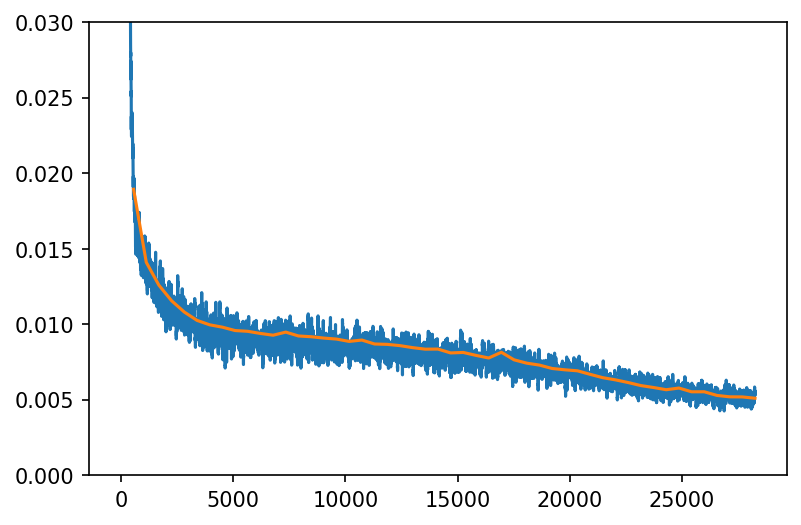

In [13]:
plt.figure(figsize=(6, 4), dpi=150)
plt.ylim(0, 0.03)

print(len(losses_show) // len(val_losses))
plt.plot(range(len(losses_show)), losses_show)
plt.plot(range(len(losses_show) // len(val_losses), len(losses_show)+1, len(losses_show) // len(val_losses)), val_losses)
plt.show()

In [14]:
model.eval()

with torch.no_grad():

    predictions = []
    # Test
    for i, data in enumerate(test_loader):
        preds = []
        features, targets = data
        i = 0
        consumption = 0
        for f, t in zip(features, targets):
            if i > 0:
                # Set previous consumption to be the last predicted consumption
                f[1] = consumption
                consumption = model(f)
                preds.append(consumption.item())
            elif i == 0:
                consumption = model(f)
                preds.append(consumption.item())
            i+=1
        
        predictions.append([preds, targets])
    



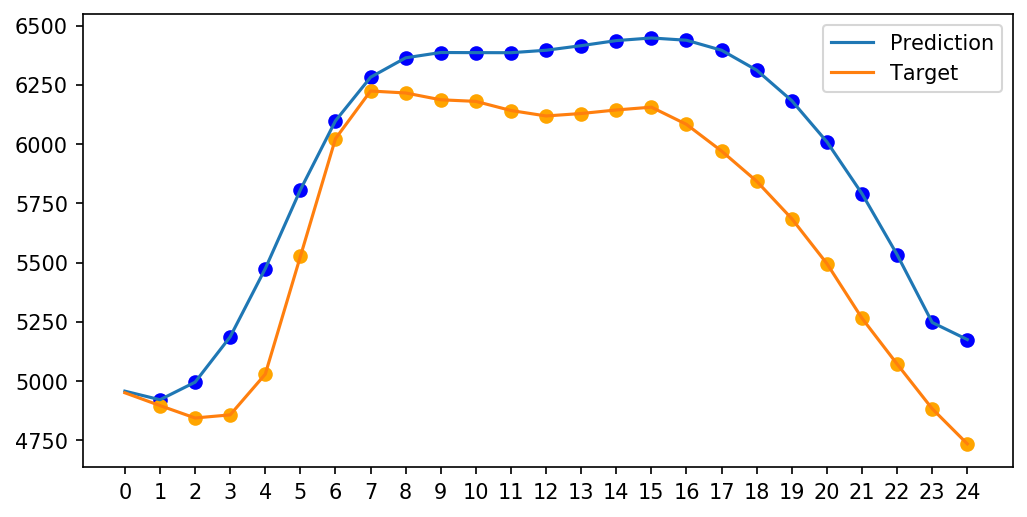

In [15]:

# Plot predictions with true values
prediction_target_plot(predictions, train_mean, train_std, 10)

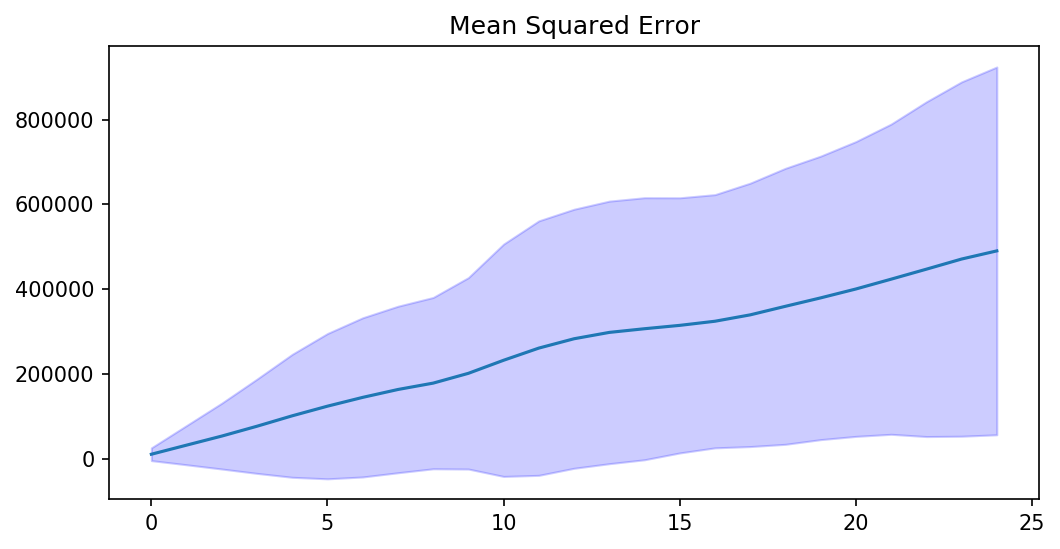

In [16]:
# Plot MSE with standard deviation
mse_plot(predictions, train_mean, train_std)